In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap as sp

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
df = pd.read_csv('ar_properties.csv')
df.head(5)

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,wdQ5hWhv8P14T7Sh9g4QCg==,Propiedad,2020-12-25,9999-12-31,2020-12-25,-32.716652,-68.642692,Argentina,Mendoza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.0,350.0,NaN,NaN,NaN,Excelentes Lotes Sobre Ruta 34,Corredor Responsable: VICTOR E. MONTIVERO - C....,Lote,Venta
1,nnMBYZ4RMRY+vm753EtA+g==,Propiedad,2020-12-25,9999-12-31,2020-12-25,-24.797723,-65.467514,Argentina,Salta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1541.0,1541.0,NaN,NaN,Mensual,TERRENO + VENTA + JARDINES DE SAN LORENZO +150...,Corredor Responsable: Pablo Castañeda - C.U.C....,Lote,Venta
2,+dnVA1K6JxzL1zAjOEQ1pA==,Propiedad,2020-12-25,2020-12-29,2020-12-25,-34.919373,-58.020591,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,NaN,NaN,NaN,NaN,NaN,1000.0,1000.0,NaN,NaN,Mensual,Lote en Venta de 1000 m2 en La Plata,Corredor Responsable: Rico Sebastián - Martill...,Lote,Venta
3,dLHXKN5/sRZpm9Yk0yI2nA==,Propiedad,2020-12-25,2020-12-29,2020-12-25,-34.919455,-58.024807,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,NaN,NaN,NaN,NaN,NaN,1000.0,1000.0,NaN,NaN,Mensual,Lote en Venta de 1000 m2 en La Plata,Corredor Responsable: Rico Sebastián - Martill...,Lote,Venta
4,wtw/k887EPipd37UYHKb1Q==,Propiedad,2020-12-25,9999-12-31,2020-12-25,-34.364924,-58.783143,Argentina,Bs.As. G.B.A. Zona Norte,Escobar,Belén de Escobar,NaN,NaN,NaN,NaN,NaN,18164.0,18164.0,NaN,NaN,Mensual,PANAMERICANA 47300,Nave principal 66 x 90 m: 6005 m2 cubiertos...,Otro,Venta


In [4]:
print(f"Dataset Shape: {df.shape}")
 
summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
summary = summary.reset_index()
summary['Name'] = summary['index']
summary['Missing'] = df.isnull().sum().values
summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
summary['Uniques'] = df.nunique().values
summary['Data type'] = df.dtypes.values
 
print('**Variable Description of  data:**')
summary

Dataset Shape: (1000000, 25)
**Variable Description of  data:**


,index,dtypes,Name,Missing,PercMissing,Uniques,Data type
0,id,object,id,0,0.000000,1000000,object
1,ad_type,object,ad_type,0,0.000000,1,object
2,start_date,object,start_date,0,0.000000,318,object
3,end_date,object,end_date,0,0.000000,450,object
4,created_on,object,created_on,0,0.000000,318,object
5,lat,float64,lat,150811,0.150811,322093,float64
6,lon,float64,lon,151745,0.151745,323811,float64
7,l1,object,l1,0,0.000000,4,object
8,l2,object,l2,0,0.000000,43,object
9,l3,object,l3,53327,0.053327,1301,object


In [5]:
target_column = ["price"]
 
numerical_column = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
 
categorical_columns = ['l1', 'l2', 'l3', 'currency', 'price_period', 'property_type', 'operation_type']
 
for l in numerical_column: df[l] = df[l].astype('float')
for l in categorical_columns: df[l] = df[l].fillna(-1).astype('category')

df = df[target_column + numerical_column + categorical_columns]

df["price"] = df["price"].replace(0, None)
df["price"] = np.where(df['price'] < 1e7, df['price'], None)
df = df.dropna(subset=["price"])
df["price"] = df["price"].astype('float')


In [6]:
#Train/test split
X = df.drop('price', axis=1)
y = df['price']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
n_train=y.size
n_test=y_test.size
 
n,p=X.shape
n_classes= np.unique(y).size
 
print("Shape of train X, y, Y: ", X_train.shape, y_train.shape)
print("Shape of test X, y, Y: ", X_test.shape, y_test.shape)

Shape of train X, y, Y:  (767118, 14) (767118,)
Shape of test X, y, Y:  (191780, 14) (191780,)


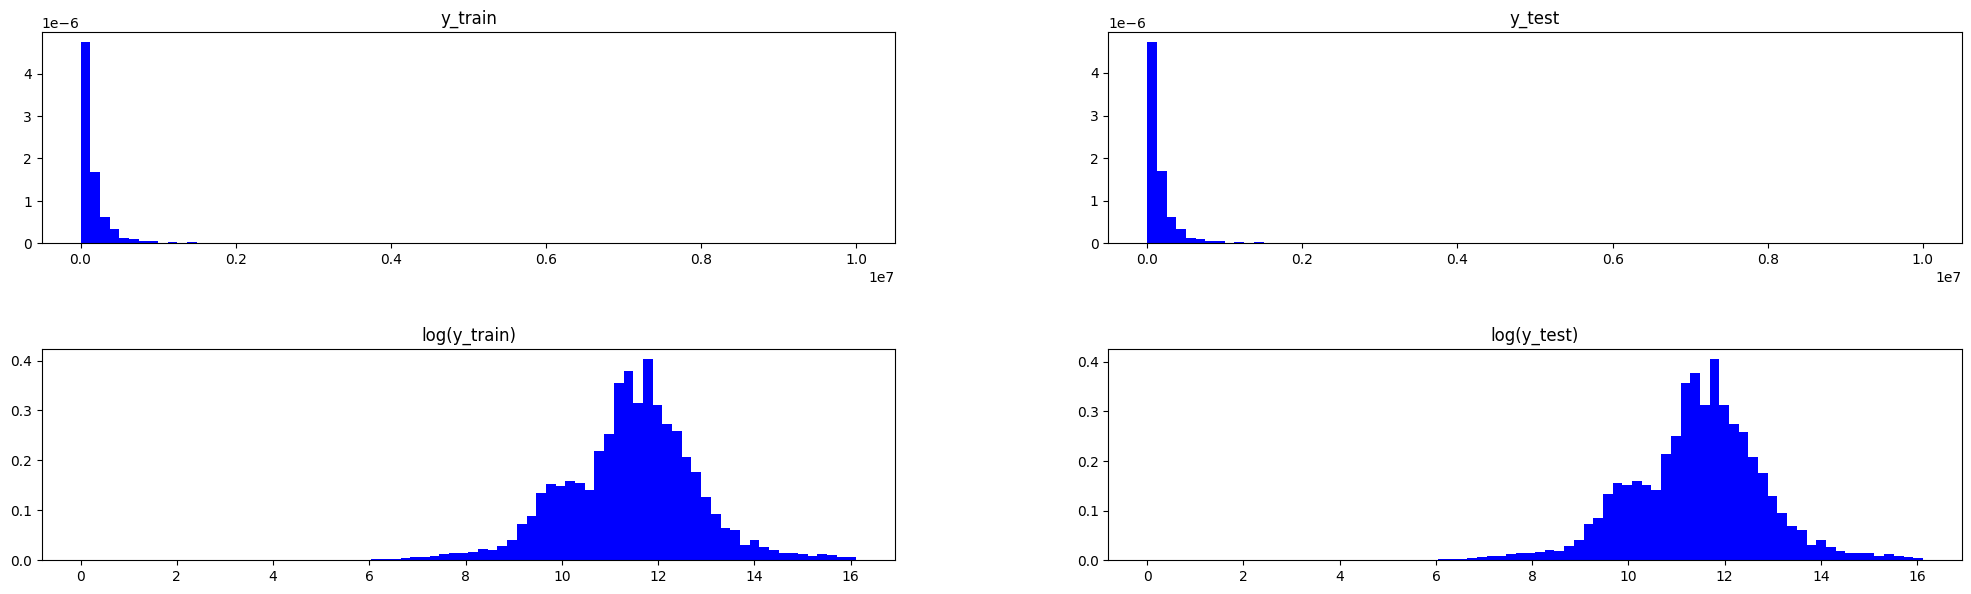

In [7]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2,ncols=2)
 
ax0.hist(y, color = 'blue', bins = 80, density= True)
ax0.set_title("y_train")
 
ax1.hist(y_test, color = 'blue', bins = 80, density= True)
ax1.set_title("y_test")
 
ax2.hist(np.log(y), color = 'blue', bins = 80, density= True)
ax2.set_title("log(y_train)")
 
ax3.hist(np.log(y_test), color = 'blue', bins = 80, density= True)
ax3.set_title("log(y_test)")
 
plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

In [8]:
#Train model
reg_catboost = CatBoostRegressor(cat_features = sorted([X.columns.get_loc(col) for col in categorical_columns]))
reg_catboost = reg_catboost.fit(X_train, y_train, verbose = 100, eval_set = (X_test, y_test))

Learning rate set to 0.144484
0:	learn: 601019.0648955	test: 584792.3453055	best: 584792.3453055 (0)	total: 729ms	remaining: 12m 8s
100:	learn: 349143.4063519	test: 340420.2117210	best: 340420.2117210 (100)	total: 1m 4s	remaining: 9m 38s
200:	learn: 336796.7621402	test: 329572.5955819	best: 329572.5955819 (200)	total: 2m 12s	remaining: 8m 48s
300:	learn: 329420.9709205	test: 323338.7879154	best: 323338.7879154 (300)	total: 3m 22s	remaining: 7m 50s
400:	learn: 324007.1784373	test: 319238.3321192	best: 319238.3321192 (400)	total: 4m 33s	remaining: 6m 48s
500:	learn: 320474.6229279	test: 316823.5190957	best: 316823.5190957 (500)	total: 5m 48s	remaining: 5m 46s
600:	learn: 317656.3013301	test: 314846.9553162	best: 314846.9553162 (600)	total: 6m 57s	remaining: 4m 37s
700:	learn: 315472.2664020	test: 313331.2746673	best: 313331.2746673 (700)	total: 8m 9s	remaining: 3m 28s
800:	learn: 312529.9662851	test: 311532.0347011	best: 311509.1678941 (799)	total: 9m 21s	remaining: 2m 19s
900:	learn: 31

In [9]:
#Result model
y_hat_train = reg_catboost.predict(X_train)
y_hat_test = reg_catboost.predict(X_test)

invalid value encountered in log


Text(0.5, 1.0, 'y_hat_test')

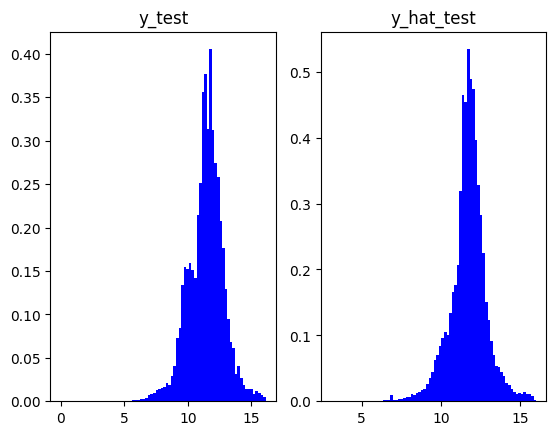

In [10]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)
 
ax0.hist(np.log(y_test), color = 'blue', bins = 80, density= True)
ax0.set_title("y_test")
 
ax1.hist(np.log(y_hat_test), color = 'blue', bins = 80, density= True)
ax1.set_title("y_hat_test")

In [11]:
#Loss
print("Train loss (RMSE): ", np.sqrt(mean_squared_error(y_train, y_hat_train)))
print("Test loss: (RMSE)", np.sqrt(mean_squared_error(y_test, y_hat_test)))
print("Test loss: (RMSE - Random)", np.std(y_test))
print("-"*50)
print("Train loss: (MAE)", mean_absolute_error(y_train, y_hat_train))
print("Test loss: (MAE)", mean_absolute_error(y_test, y_hat_test))
print("Test loss: (MAE - Random))", np.linalg.norm(y_test-y_train.mean(),1)/n_test)
print("-"*50)
print("Train loss: (VAR)", explained_variance_score(y_train, y_hat_train))
print("Test loss: (VAR)", explained_variance_score(y_test, y_hat_test))

Train loss (RMSE):  309514.3958696936
Test loss: (RMSE) 309132.95970224024
Test loss: (RMSE - Random) 638257.8454919452
--------------------------------------------------
Train loss: (MAE) 96740.97045211148
Test loss: (MAE) 97214.5640475142
Test loss: (MAE - Random)) 248691.8740633118
--------------------------------------------------
Train loss: (VAR) 0.7765723391256989
Test loss: (VAR) 0.765424100163886


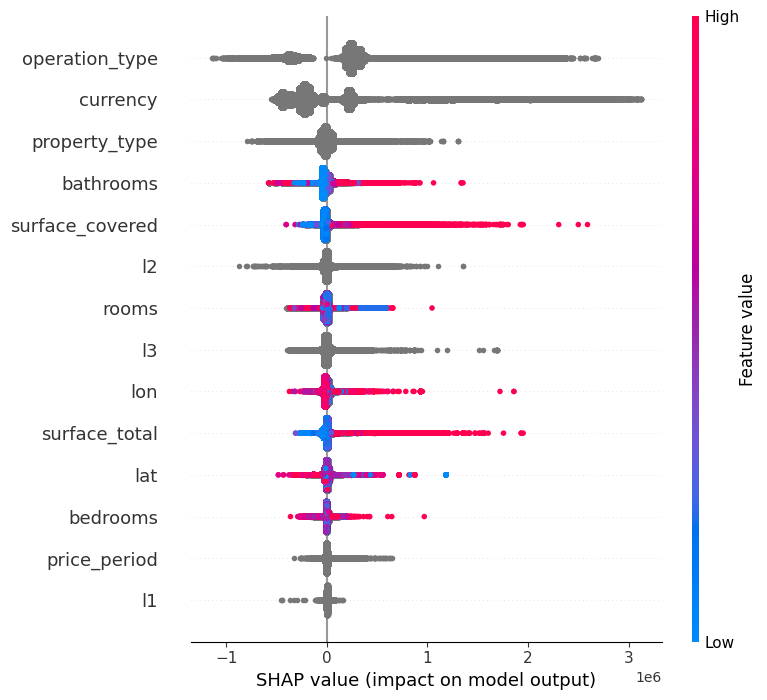

In [12]:
explainer = sp.TreeExplainer(reg_catboost)
shap_values = explainer.shap_values(X_train)
 
sp.summary_plot(shap_values, X_train)

In [13]:
#Train model
reg_catboost2 = CatBoostRegressor(cat_features = sorted([X.columns.get_loc(col) for col in categorical_columns]))
reg_catboost2 = reg_catboost2.fit(X_train, np.log(y_train), verbose = 100, eval_set = (X_test, np.log(y_test)))

Learning rate set to 0.144484
0:	learn: 1.2509174	test: 1.2492867	best: 1.2492867 (0)	total: 711ms	remaining: 11m 50s
100:	learn: 0.6037019	test: 0.6017670	best: 0.6017670 (100)	total: 1m 8s	remaining: 10m 5s
200:	learn: 0.5789115	test: 0.5769008	best: 0.5769008 (200)	total: 2m 19s	remaining: 9m 13s
300:	learn: 0.5658110	test: 0.5642073	best: 0.5642073 (300)	total: 3m 29s	remaining: 8m 7s
400:	learn: 0.5573841	test: 0.5561366	best: 0.5561366 (400)	total: 4m 41s	remaining: 7m
500:	learn: 0.5503599	test: 0.5498105	best: 0.5498105 (500)	total: 5m 52s	remaining: 5m 50s
600:	learn: 0.5444196	test: 0.5441921	best: 0.5441921 (600)	total: 7m 5s	remaining: 4m 42s
700:	learn: 0.5390954	test: 0.5394006	best: 0.5394006 (700)	total: 8m 18s	remaining: 3m 32s
800:	learn: 0.5354114	test: 0.5362235	best: 0.5362235 (800)	total: 9m 30s	remaining: 2m 21s
900:	learn: 0.5317731	test: 0.5330032	best: 0.5330032 (900)	total: 10m 42s	remaining: 1m 10s
999:	learn: 0.5289353	test: 0.5305670	best: 0.5305670 (999)	

In [14]:
#Result model
y_hat_train = np.exp(reg_catboost2.predict(X_train))
y_hat_test = np.exp(reg_catboost2.predict(X_test))

Text(0.5, 1.0, 'y_hat_test')

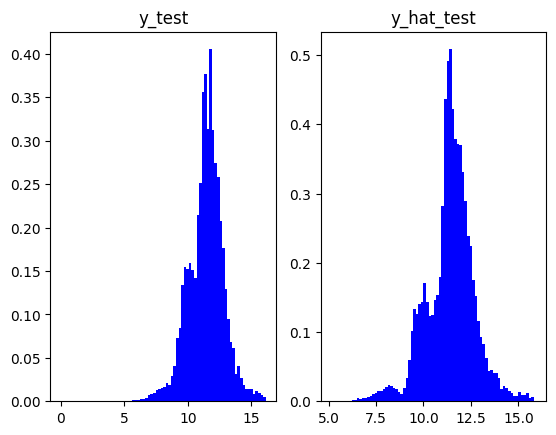

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)
 
ax0.hist(np.log(y_test), color = 'blue', bins = 80, density= True)
ax0.set_title("y_test")
 
ax1.hist(np.log(y_hat_test), color = 'blue', bins = 80, density= True)
ax1.set_title("y_hat_test")

In [16]:
#Loss
print("Train loss (RMSE): ", np.sqrt(mean_squared_error(y_train, y_hat_train)))
print("Test loss: (RMSE)", np.sqrt(mean_squared_error(y_test, y_hat_test)))
print("Test loss: (RMSE - Random)", np.std(y_test))
print("-"*50)
print("Train loss: (MAE)", mean_absolute_error(y_train, y_hat_train))
print("Test loss: (MAE)", mean_absolute_error(y_test, y_hat_test))
print("Test loss: (MAE - Random))", np.linalg.norm(y_test-y_train.mean(),1)/n_test)
print("-"*50)
print("Train loss: (VAR)", explained_variance_score(y_train, y_hat_train))
print("Test loss: (VAR)", explained_variance_score(y_test, y_hat_test))

Train loss (RMSE):  345958.6780442199
Test loss: (RMSE) 335722.7885657766
Test loss: (RMSE - Random) 638257.8454919452
--------------------------------------------------
Train loss: (MAE) 87907.86478574891
Test loss: (MAE) 87047.71726615954
Test loss: (MAE - Random)) 248691.8740633118
--------------------------------------------------
Train loss: (VAR) 0.7239435802436202
Test loss: (VAR) 0.7263854437254385
